### 오토인코더

**오토인코더**
- 레이블 없이 특징을 추출하는 신경망 - 비지도 학습
- 입력 x만 있고 정답 y가 없으므로 x를 입력받아 x를 예측하여  
신경망에 의미 있는 정보가 쌓이도록 설계한 신경망

**범용 근사자**
- 오토인코더에서 입력도 x이고 정답도 x이지만 x의  
근사치를 출력하기 때문에 범용 근사자라고 함

**정보 손실값**
- 오차값이 x를 얼마나 복원했는지를 뜻하므로 복원오차  
또는 정보손실값이란 용어를 사용

**오토인코더 특징**
- 입력과 출력은 같지만 중간으로 갈수록 신경망의  
차수가 줄어 입력 특징들이 압축된다
- 이때 압축된 값을 잠재변수라고 한다

**인코더**
- 잠재변수의 앞부분으로 정보를 입력받아 압축하는 부분

**디코더**
- 잠재변수의 뒷부분으로 압축된 표현을 풀어 입력 데이터로 복원하는 부분

**압축의 의미**
- 압축 과정에서 손실로 원본 데이터의 디테일을 잃어버리지만  
중요한 정보를 남겨두는 일종의 데이터 가공

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('Using Device:', DEVICE)

Using Device: cpu


**Fashion MNIST 데이터셋에서 훈련 데이터셋을 순서를 변환하여 배치크기만큼 가져온다**

In [0]:
trainset = datasets.FashionMNIST(
    root='./.data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

**오토인코더 모듈 정의**
- 인코더
  - 784개의 차원에서 128개, 64개, 12개, 3개의 차원으로 압축
  - 인코더의 출력값은 잠재변수가 된다
- 디코더
  - 3차원의 잠재변수를 역으로 차원을 12, 64, 128, 784개로 복원

**잡음제거 오토인코더의 아이디어**
- 중요한 특징을 추출하는 오토인코더의 특성을 이용하여 비교적 덜 중요한  
데이터인 잡음을 버려 원래의 데이터를 복원한다

In [0]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3),
    )
    self.decoder = nn.Sequential(
        nn.Linear(3, 12),
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28 * 28),
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [0]:
autoencoder = AutoEncoder().to(DEVICE)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)  # 최적화 함수
criterion = nn.MSELoss()  # 오차계산 - 평균제곱 오차

**이미지에 잡음 추가하는 함수 생성**

In [0]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.2
  noisy_img = img + noise
  return noisy_img

**모델 훈련 함수 생성**

In [0]:
def train(autoencoder, train_loader):
  autoencoder.train()
  avg_loss = 0

  for step, (x, label) in enumerate(train_loader):
    x = add_noise(x)  # 입력에 잡음 추가
    x = x.view(-1, 28 * 28).to(DEVICE)
    y = x.view(-1, 28 * 28).to(DEVICE)
    label = label.to(DEVICE)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()  # 가중치 초기화
    loss.backward()  # 가중치의 변화율 계산
    optimizer.step()  # 가중치 업데이트

    avg_loss += loss.item()
  return avg_loss / len(train_loader)

**모델 훈련**

In [17]:
for epoch in range(1, EPOCH + 1):
  loss = train(autoencoder, train_loader)
  print('[Epoch {}] loss: {}'.format(epoch, loss))

[Epoch 1] loss: 0.06242898306739864
[Epoch 2] loss: 0.06206044615871871
[Epoch 3] loss: 0.062013303432097315
[Epoch 4] loss: 0.06198120617202477
[Epoch 5] loss: 0.06179012923733766
[Epoch 6] loss: 0.06180683395533419
[Epoch 7] loss: 0.06166763785980277
[Epoch 8] loss: 0.061718739652589186
[Epoch 9] loss: 0.0617183042622642
[Epoch 10] loss: 0.06154812463342762


**테스트 샘플 이미지 복원하기**

In [0]:
testset = datasets.FashionMNIST(
    root='./.data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# 테스트셋에서 이미지 한장 가져오기
sample_data = testset.data[0].view(-1, 28 * 28)
sample_data = sample_data.type(torch.FloatTensor) / 255.

**이미지에 잡음 추가 후, 모델에 통과**

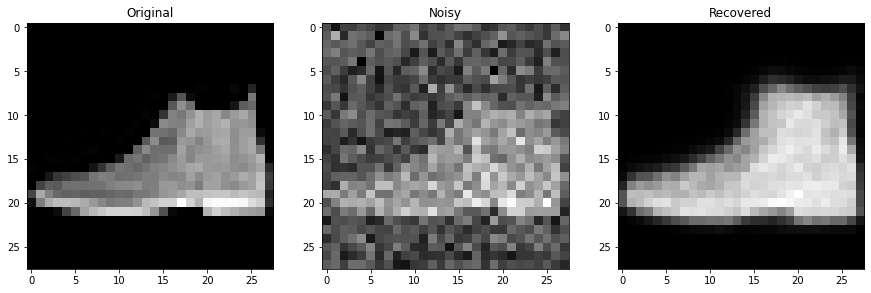

In [20]:
original_x = sample_data[0]  # 원본 이미지
noisy_x = add_noise(original_x).to(DEVICE)  # 잡음 추가한 이미지
_, recovered_x = autoencoder(noisy_x)  # 복원된 이미지

f, a = plt.subplots(1, 3, figsize=(15, 15))

# 시각화를 위해 넘파이 행렬로 변환
original_img = np.reshape(original_x.to(DEVICE).data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to(DEVICE).data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to(DEVICE).data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()